# Optimizing Stock Portfolio Allocation <a class='tocSkip'>

## Sang-Yun Oh <a class='tocSkip'>

## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/yfinance/
* Can also install from github repository: 
    https://pypi.org/project/yfinance/

In [1]:
# install from pypi
!pip install yfinance

In [2]:
# install from github
# ! pip install git+https://github.com/ranaroussi/yfinance

In [3]:
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [4]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [5]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [6]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.1003
B: mean = 0.10, std = 0.0502
p: mean = 0.13, std = 0.0297
cor(R_A, R_B) = -0.8987


### Empirical Portfolio Returns

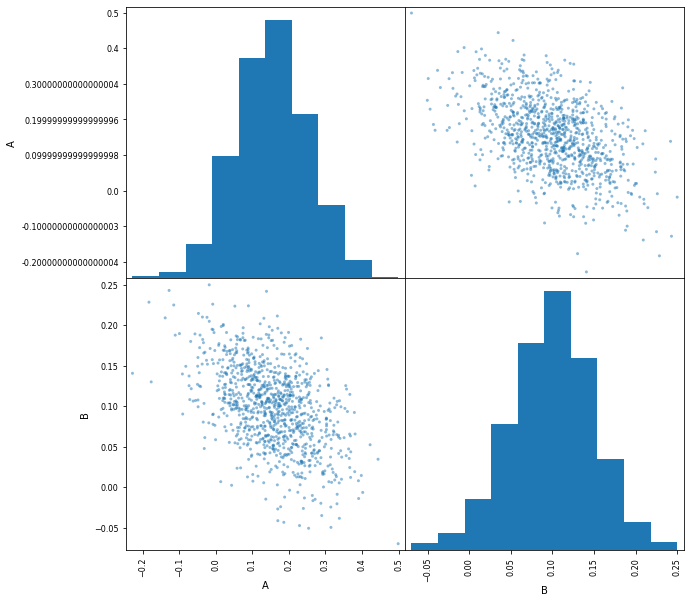

In [7]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [8]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [9]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig']))
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


#### Empirical (Data) Properties 

In [10]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.0999
B: mean = 0.10, std = 0.0504
p: mean = 0.13, std = 0.0294
corr(A, B) = -0.9018


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [11]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

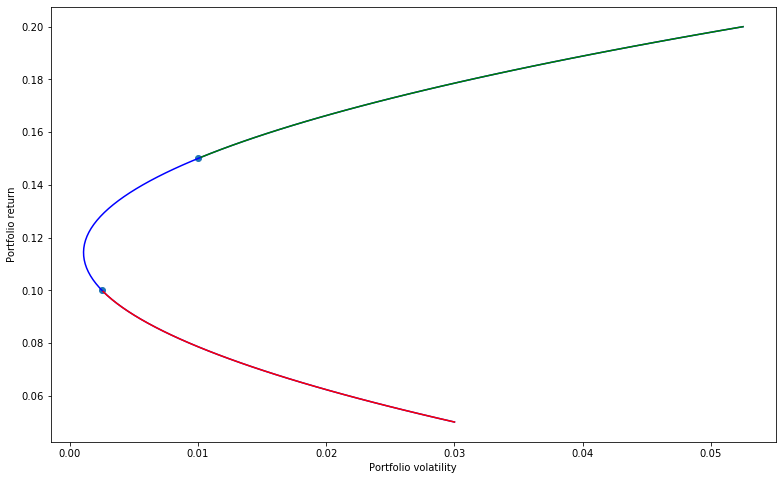

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$ x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1} $$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

## Portfolio Allocation: Dow Jones component stocks

Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies 

In [13]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','UTX','VZ','WMT','XOM'
]

symbols = pd.read_csv('data/tickers.csv').set_index('code')

import yfinance as yf
rawdata = yf.download(dowjones_components, start="2000-01-01", end="2020-05-10")
rawdata.head()

[*********************100%***********************]  29 of 29 completed


Adj Close                                                         \
                AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  3.460857  34.683704  25.741438  14.306108  11.845388  41.433525   
2000-01-04  3.169071  33.374104  25.701408  13.456975  11.693136  39.109055   
2000-01-05  3.215448  32.526413  27.302753  13.604647  11.967190  38.989223   
2000-01-06  2.937188  33.189102  27.582977  14.767599  12.576205  38.342190   

                                                        ...     Volume  \
                  CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  17.419516  31.433344  23.115221  26.297499  ...  5978800.0   
2000-01-04  17.419516  30.574173  24.469255  25.245590  ...  7533100.0   
2000-01-05  17.731968  31.566656  25.484774  25.201761  ...  7598300.0   
2000-01-06  18.487068  32.455444  24.469255  25.538691  ...  4760500.0   

                                                                               \
                  MSFT         PFE         PG          T       TRV        UTX   
Date                                                                            
1999-12-31         NaN         NaN        NaN        NaN       NaN        NaN   
2000-01-03  53228400.0  12213800.0  4275000.0  5791900.0  336400.0  2140400.0   
2000-01-04  54119000.0  13481000.0  4270800.0  7173600.0  494400.0  3367000.0   
2000-01-05  64059600.0  12316500.0  5098400.0  9090000.0  736000.0  3904600.0   
2000-01-06  54976600.0  10545800.0  6524200.0  7153600.0  660400.0  6148600.0   

                                              
                   VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663700.0  8369900.0  13458200.0  
2000-01-04  5005800.0  6745100.0  14510800.0  
2000-01-05  6368500.0  7018700.0  17485000.0  
2000-01-06  4705600.0  6544500.0  19461600.0  

[5 rows x 174 columns]

In [14]:
symbols # full company names

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


## Data Format

### Hierarchical Indexing

* Column indexing is hierarchical
* Adjusted close, close, high, low, open, and volume are given for each stock symbol

In [15]:
rawdata.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD', 'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'UTX', 'VZ', 'WMT', 'XOM']])

* Column levels can be named:

In [16]:
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  3.460857  34.683704  25.741438  14.306108  11.845388  41.433525   
2000-01-04  3.169071  33.374104  25.701408  13.456975  11.693136  39.109055   
2000-01-05  3.215448  32.526413  27.302753  13.604647  11.967190  38.989223   
2000-01-06  2.937188  33.189102  27.582977  14.767599  12.576205  38.342190   

Value                                                   ...     Volume  \
Symbol            CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  17.419516  31.433344  23.115221  26.297499  ...  5978800.0   
2000-01-04  17.419516  30.574173  24.469255  25.245590  ...  7533100.0   
2000-01-05  17.731968  31.566656  25.484774  25.201761  ...  7598300.0   
2000-01-06  18.487068  32.455444  24.469255  25.538691  ...  4760500.0   

Value                                                                          \
Symbol            MSFT         PFE         PG          T       TRV        UTX   
Date                                                                            
1999-12-31         NaN         NaN        NaN        NaN       NaN        NaN   
2000-01-03  53228400.0  12213800.0  4275000.0  5791900.0  336400.0  2140400.0   
2000-01-04  54119000.0  13481000.0  4270800.0  7173600.0  494400.0  3367000.0   
2000-01-05  64059600.0  12316500.0  5098400.0  9090000.0  736000.0  3904600.0   
2000-01-06  54976600.0  10545800.0  6524200.0  7153600.0  660400.0  6148600.0   

Value                                         
Symbol             VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663700.0  8369900.0  13458200.0  
2000-01-04  5005800.0  6745100.0  14510800.0  
2000-01-05  6368500.0  7018700.0  17485000.0  
2000-01-06  4705600.0  6544500.0  19461600.0  

[5 rows x 174 columns]

* Subsetting first level of hierarchical indexing: `Adj Close`

In [17]:
rawdata['Adj Close'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,3.460857,34.683704,25.741438,14.306108,11.845388,41.433525,17.419516,31.433344,23.115221,26.297499,...,31.689192,37.393559,15.987980,30.989897,17.282593,19.621847,19.131641,21.479733,45.984715,21.818495
2000-01-04,3.169071,33.374104,25.701408,13.456975,11.693136,39.109055,17.419516,30.574173,24.469255,25.245590,...,30.576269,36.130390,15.392351,30.393608,16.271378,19.361706,18.347233,20.785389,44.264072,21.400583
2000-01-05,3.215448,32.526413,27.302753,13.604647,11.967190,38.989223,17.731968,31.566656,25.484774,25.201761,...,31.777040,36.511333,15.643135,29.815363,16.524181,19.213058,17.983746,21.479733,43.360710,22.567265
2000-01-06,2.937188,33.189102,27.582977,14.767599,12.576205,38.342190,18.487068,32.455444,24.469255,25.538691,...,32.040642,35.288280,16.207415,31.188662,16.175280,19.584684,18.844660,21.370630,43.833904,23.733942


* Subsetting first level of hierarchical indexing: `Volume`

In [18]:
rawdata.loc[:, 'Volume'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,133949200.0,6471200.0,2638200.0,13705800.0,5055000.0,53076000.0,4387600.0,1296000.0,8402200.0,22952500.0,...,5978800.0,53228400.0,12213800.0,4275000.0,5791900.0,336400.0,2140400.0,4663700.0,8369900.0,13458200.0
2000-01-04,128094400.0,10440800.0,3592100.0,27293400.0,6181400.0,50805600.0,3702400.0,2073600.0,16051100.0,23006200.0,...,7533100.0,54119000.0,13481000.0,4270800.0,7173600.0,494400.0,3367000.0,5005800.0,6745100.0,14510800.0
2000-01-05,194580400.0,8646200.0,7631700.0,22855600.0,6398600.0,68524000.0,5567600.0,3653200.0,19823800.0,28384500.0,...,7598300.0,64059600.0,12316500.0,5098400.0,9090000.0,736000.0,3904600.0,6368500.0,7018700.0,17485000.0
2000-01-06,191993200.0,10990900.0,4922200.0,17307000.0,5140600.0,48242600.0,4353400.0,4885500.0,7903100.0,20668100.0,...,4760500.0,54976600.0,10545800.0,6524200.0,7153600.0,660400.0,6148600.0,4705600.0,6544500.0,19461600.0


* Subsetting second level is slightly harder: `AAPL`

In [19]:
idx = pd.IndexSlice
rawdata.loc[:, idx[:, 'AAPL']].head()

Value,Adj Close,Close,High,Low,Open,Volume
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,3.460857,3.997768,4.017857,3.631696,3.745536,133949200.0
2000-01-04,3.169071,3.660714,3.950893,3.613839,3.866071,128094400.0
2000-01-05,3.215448,3.714286,3.948661,3.678571,3.705357,194580400.0
2000-01-06,2.937188,3.392857,3.821429,3.392857,3.790179,191993200.0


* Subsetting `Open`, `High`, `Low`, and `Close` (OHLC) for `AAPL`:

In [20]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']]
aapl.head()

Value,Close,High,Low,Open
Symbol,AAPL,AAPL,AAPL,AAPL
Date,,,,
1999-12-31,NaN,NaN,NaN,NaN
2000-01-03,3.997768,4.017857,3.631696,3.745536
2000-01-04,3.660714,3.950893,3.613839,3.866071
2000-01-05,3.714286,3.948661,3.678571,3.705357
2000-01-06,3.392857,3.821429,3.392857,3.790179


* Drop redudant index level, `AAPL`:

In [21]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']].droplevel('Symbol', axis=1).tail(60)
aapl.head()

Value,Close,High,Low,Open
Date,,,,
2020-02-13,324.869995,326.220001,323.350006,324.190002
2020-02-14,324.950012,325.980011,322.850006,324.739990
2020-02-18,319.000000,319.750000,314.609985,315.359985
2020-02-19,323.619995,324.570007,320.000000,320.000000
2020-02-20,320.299988,324.649994,318.209991,322.630005


### Example Figure: Candlestick Chart for 3M

In [22]:
mmm = rawdata.loc[:, idx['Close':'Open', 'MMM']].droplevel('Symbol', axis=1).tail(60)

import altair as alt

open_close_color = alt.condition(
    "datum.Open <= datum.Close",
    alt.value("#06982d"), # green for increase
    alt.value("#ae1325"), # red for decrease
) 

base = alt.Chart(mmm.reset_index()).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m-%d-%Y',
              labelAngle=-90)
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

### Example Figure: Adjusted close prices

In [23]:
first10 = rawdata.loc[:, idx['Adj Close', ['MMM', 'MRK', 'PFE', 'PG', 'UNH', 'JNJ']]].tail(60)
first10.head()

Value        Adj Close                                              
Symbol             JNJ         MMM        MRK        PFE          PG
Date                                                                
2020-02-13  149.138992  159.759995  81.298386  36.565590  124.132164
2020-02-14  149.178741  161.009995  81.972816  36.149734  125.304344
2020-02-18  148.195007  158.880005  81.784370  35.961609  124.042763
2020-02-19  147.996277  159.339996  81.328140  35.872498  124.608986
2020-02-20  147.429886  158.559998  81.814125  35.496246  125.741432

* Stacking transforms data into long-format:  
    _Note: unstack does the opposite_

In [24]:
healthcare = first10.stack('Symbol')
healthcare

Value               Adj Close
Date       Symbol            
2020-02-13 JNJ     149.138992
           MMM     159.759995
           MRK      81.298386
           PFE      36.565590
           PG      124.132164
...                       ...
2020-05-08 JNJ     148.699997
           MMM     148.509995
           MRK      76.400002
           PFE      37.220001
           PG      115.949997

[300 rows x 1 columns]

In [25]:
base = alt.Chart(healthcare.reset_index()).mark_line().encode(
    x=alt.X('Date:T',
            axis=alt.Axis(
                format='%m-%d-%Y',
                labelAngle=-90)
    ),
    y='Adj Close:Q',
    color='Symbol:N'
)
base

alt.Chart(...)

* Inspect missing values:  

In [26]:
rawdata['Adj Close'].isna().sum(axis=0)

Symbol
AAPL     3
AXP      3
BA       3
BAC      3
CAT      3
CSCO     3
CVX      3
DD       3
DIS      3
GE       3
HD       3
HPQ      3
IBM      3
INTC     3
JNJ      3
JPM      3
KO       3
MCD      3
MMM      3
MRK      3
MSFT     3
PFE      3
PG       3
T        3
TRV      3
UTX     25
VZ       3
WMT      3
XOM      3
dtype: int64

In [27]:
anymissing = rawdata['Adj Close'].isna().any(axis=1)
rawdata.loc[anymissing]

Value        Adj Close                                                \
Symbol            AAPL        AXP          BA        BAC         CAT   
Date                                                                   
1999-12-31         NaN        NaN         NaN        NaN         NaN   
2001-09-12         NaN        NaN         NaN        NaN         NaN   
2016-01-18         NaN        NaN         NaN        NaN         NaN   
2020-04-08  265.351715  92.080002  146.869995  23.450001  126.240997   
2020-04-09  267.266510  94.820000  151.839996  24.860001  123.892555   
2020-04-13  272.512329  90.330002  147.330002  23.920000  113.101631   
2020-04-14  286.275055  88.389999  141.000000  23.730000  115.420349   
2020-04-15  283.662140  83.790001  145.979996  22.190001  110.515373   
2020-04-16  285.916046  81.349998  134.240005  21.420000  112.190002   
2020-04-17  282.036530  87.389999  154.000000  23.280001  116.300003   
2020-04-20  276.182373  84.010002  143.610001  22.500000  114.599998   
2020-04-21  267.645477  81.519997  136.330002  21.639999  109.849998   
2020-04-22  275.354614  82.540001  134.970001  21.799999  110.639999   
2020-04-23  274.287506  82.459999  137.740005  21.870001  112.910004   
2020-04-24  282.206085  83.169998  128.979996  22.180000  114.040001   
2020-04-27  282.405548  85.059998  128.679993  23.469999  115.199997   
2020-04-28  277.827911  88.190002  131.300003  23.889999  115.459999   
2020-04-29  286.953247  96.120003  139.000000  24.780001  120.059998   
2020-04-30  293.006836  91.250000  141.020004  24.049999  116.379997   
2020-05-01  288.289612  88.320000  133.369995  23.080000  110.879997   
2020-05-04  292.368561  86.379997  131.460007  22.930000  107.720001   
2020-05-05  296.756683  86.739998  125.400002  22.660000  108.910004   
2020-05-06  299.818390  84.000000  121.860001  22.350000  107.669998   
2020-05-07  302.919983  86.730003  128.649994  22.840000  107.290001   
2020-05-08  310.130005  89.500000  133.440002  23.570000  112.110001   

Value                                                          ...  \
Symbol           CSCO        CVX         DD         DIS    GE  ...   
Date                                                           ...   
1999-12-31        NaN        NaN        NaN         NaN   NaN  ...   
2001-09-12        NaN        NaN        NaN         NaN   NaN  ...   
2016-01-18        NaN        NaN        NaN         NaN   NaN  ...   
2020-04-08  41.740002  85.980003  38.860001  101.070000  7.30  ...   
2020-04-09  41.200001  84.309998  40.779999  104.500000  7.14  ...   
2020-04-13  41.220001  84.910004  38.320000  103.500000  7.02  ...   
2020-04-14  42.779999  84.610001  38.430000  106.029999  6.93  ...   
2020-04-15  41.520000  82.489998  35.570000  103.370003  6.50  ...   
2020-04-16  41.500000  79.989998  36.220001  102.019997  6.24  ...   
2020-04-17  42.480000  87.169998  38.360001  106.629997  6.84  ...   
2020-04-20  42.540001  83.570000  39.720001  102.260002  6.51  ...   
2020-04-21  40.549999  81.639999  39.070000  100.540001  6.48  ...   
2020-04-22  41.759998  84.440002  39.869999  100.989998  6.43  ...   
2020-04-23  41.619999  86.800003  41.200001  101.000000  6.52  ...   
2020-04-24  42.520000  87.010002  41.900002  101.190002  6.26  ...   
2020-04-27  43.060001  89.709999  43.820000  106.059998  6.43  ...   
2020-04-28  42.490002  89.910004  46.410000  106.209999  6.80  ...   
2020-04-29  43.340000  94.620003  48.169998  112.250000  6.58  ...   
2020-04-30  42.380001  92.000000  47.020000  108.150002  6.80  ...   
2020-05-01  40.919998  89.440002  45.070000  105.500000  6.50  ...   
2020-05-04  41.349998  91.440002  44.720001  103.180000  6.21  ...   
2020-05-05  41.459999  92.889999  44.689999  101.059998  6.20  ...   
2020-05-06  41.150002  90.050003  44.040001  100.879997  5.98  ...   
2020-05-07  41.369999  92.639999  44.759998  105.570000  6.11  ...   
2020-05-08  42.990002  95.470001  46.930000  109.160004  6.29  ...   

Value           Volume

* Raytheon bought United Technologies in April  
    Let's remove UTX and keep other recent data
* Remove missing day: '1999-12-31'
* Fill '2001-09-12', '2016-01-18' with [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [28]:
data_all = pd.concat([
    rawdata.loc[:, idx[:, :'TRV']], 
    rawdata.loc[:, idx[:, 'VZ':]], 
], axis=1).fillna(method='pad').loc['2000-01-03':]

data_all.columns = data_all.columns.set_names(['Value', 'Symbol'])

* Double check: did we remove all missing values?

In [29]:
(data_all.isna().sum(axis=None)>0).any()

False

* Reset symbols to what is in `data` variable

In [30]:
symbols = symbols.loc[data_all.columns.levels[1].to_list()]
symbols

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


In [31]:
data_all.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  3.460857  34.683704  25.741438  14.306108  11.845388  41.433525   
2000-01-04  3.169071  33.374104  25.701408  13.456975  11.693136  39.109055   
2000-01-05  3.215448  32.526413  27.302753  13.604647  11.967190  38.989223   
2000-01-06  2.937188  33.189102  27.582977  14.767599  12.576205  38.342190   
2000-01-07  3.076317  33.672298  28.383648  14.379949  12.987292  40.594810   

Value                                                   ...      High  \
Symbol            CVX         DD        DIS         GE  ...       XOM   
Date                                                    ...             
2000-01-03  17.419516  31.433344  23.115221  26.297499  ...  40.37500   
2000-01-04  17.419516  30.574173  24.469255  25.245590  ...  39.09375   
2000-01-05  17.731968  31.566656  25.484774  25.201761  ...  40.87500   
2000-01-06  18.487068  32.455444  24.469255  25.538691  ...  42.90625   
2000-01-07  18.812553  33.181282  24.082386  26.527594  ...  43.12500   

Value             Low                          Open                    \
Symbol             VZ      WMT       XOM         VZ     WMT       XOM   
Date                                                                    
2000-01-03  53.622120  65.5000  38.93750  54.521442  68.375  39.75000   
2000-01-04  51.486229  64.1875  38.25000  53.678326  65.500  38.68750   
2000-01-05  52.610382  62.1875  38.90625  53.060043  63.875  39.00000   
2000-01-06  52.497967  62.6875  40.09375  53.678326  63.000  40.31250   
2000-01-07  51.992096  64.5000  42.00000  52.947628  64.500  42.96875   

Value          Volume                         
Symbol             VZ        WMT         XOM  
Date                                          
2000-01-03  4663700.0  8369900.0  13458200.0  
2000-01-04  5005800.0  6745100.0  14510800.0  
2000-01-05  6368500.0  7018700.0  17485000.0  
2000-01-06  4705600.0  6544500.0  19461600.0  
2000-01-07  5043800.0  7976900.0  16603800.0  

[5 rows x 168 columns]

### Adjusted Close

* [Adjusted closing prices](https://help.yahoo.com/kb/SLN28256.html) accounts for splits, etc

In [32]:
data = data_all['Adj Close']
data.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.460857,34.683704,25.741438,14.306108,11.845388,41.433525,17.419516,31.433344,23.115221,26.297499,...,28.592686,31.689192,37.393559,15.987980,30.989897,17.282593,19.621847,21.479733,45.984715,21.818495
2000-01-04,3.169071,33.374104,25.701408,13.456975,11.693136,39.109055,17.419516,30.574173,24.469255,25.245590,...,27.456560,30.576269,36.130390,15.392351,30.393608,16.271378,19.361706,20.785389,44.264072,21.400583
2000-01-05,3.215448,32.526413,27.302753,13.604647,11.967190,38.989223,17.731968,31.566656,25.484774,25.201761,...,28.251841,31.777040,36.511333,15.643135,29.815363,16.524181,19.213058,21.479733,43.360710,22.567265
2000-01-06,2.937188,33.189102,27.582977,14.767599,12.576205,38.342190,18.487068,32.455444,24.469255,25.538691,...,30.524109,32.040642,35.288280,16.207415,31.188662,16.175280,19.584684,21.370630,43.833904,23.733942
2000-01-07,3.076317,33.672298,28.383648,14.379949,12.987292,40.594810,18.812553,33.181282,24.082386,26.527594,...,31.130033,35.115833,35.749432,17.304638,33.682331,16.313929,20.365091,21.212824,47.146187,23.664276


### Log returns from stock prices

* Data is price per share
* We need daily returns from the prices
* Given the prices $P_t$ and $P_{t-1}$ for time $t$, the return is, 
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Approximation $\log(1+x)\approx x$ is good when $x$ is small
* Since daily returns of stocks are small, calculate as returns,
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [33]:
logret = np.log(data).diff()
logret.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088078,-0.038490,-0.001556,-0.061189,-0.012937,-0.057736,0.000000,-0.027714,0.056926,-0.040822,...,-0.040546,-0.035751,-0.034364,-0.037966,-0.019429,-0.060292,-0.013346,-0.032860,-0.038136,-0.019340
2000-01-05,0.014528,-0.025728,0.060442,0.010914,0.023167,-0.003069,0.017778,0.031946,0.040664,-0.001738,...,0.028553,0.038520,0.010488,0.016161,-0.019209,0.015417,-0.007707,0.032860,-0.020620,0.053082
2000-01-06,-0.090514,0.020169,0.010211,0.082024,0.049638,-0.016734,0.041702,0.027767,-0.040664,0.013281,...,0.077358,0.008261,-0.034072,0.035437,0.045031,-0.021341,0.019158,-0.005092,0.010854,0.050406
2000-01-07,0.046280,0.014454,0.028614,-0.026601,0.032165,0.057089,0.017453,0.022118,-0.015937,0.037991,...,0.019656,0.091647,0.012983,0.065506,0.076919,0.008535,0.039074,-0.007412,0.072846,-0.002940


* First time period is NaN since there is no data corresponding to $-1$.

* Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [34]:
mu = logret[1:].mean()
mu

Symbol
AAPL    0.000878
AXP     0.000185
BA      0.000321
BAC     0.000097
CAT     0.000439
CSCO    0.000007
CVX     0.000332
DD      0.000078
DIS     0.000303
GE     -0.000279
HD      0.000329
HPQ     0.000018
IBM     0.000098
INTC    0.000150
JNJ     0.000329
JPM     0.000244
KO      0.000263
MCD     0.000396
MMM     0.000322
MRK     0.000172
MSFT    0.000312
PFE     0.000165
PG      0.000258
T       0.000106
TRV     0.000313
VZ      0.000191
WMT     0.000192
XOM     0.000143
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [35]:
sigma = logret.cov()
sigma

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000710,0.000221,0.000162,0.000240,0.000201,0.000297,0.000128,0.000171,0.000176,0.000195,...,0.000129,0.000095,0.000229,0.000093,0.000067,0.000120,0.000142,0.000104,0.000101,0.000121
AXP,0.000221,0.000524,0.000242,0.000444,0.000255,0.000251,0.000198,0.000271,0.000246,0.000284,...,0.000183,0.000147,0.000215,0.000152,0.000111,0.000169,0.000239,0.000148,0.000129,0.000176
BA,0.000162,0.000242,0.000447,0.000250,0.000205,0.000180,0.000172,0.000224,0.000188,0.000212,...,0.000148,0.000114,0.000165,0.000120,0.000090,0.000122,0.000166,0.000101,0.000098,0.000156
BAC,0.000240,0.000444,0.000250,0.000848,0.000295,0.000266,0.000221,0.000322,0.000249,0.000335,...,0.000208,0.000153,0.000220,0.000171,0.000119,0.000180,0.000275,0.000153,0.000126,0.000192
CAT,0.000201,0.000255,0.000205,0.000295,0.000421,0.000203,0.000187,0.000274,0.000185,0.000223,...,0.000182,0.000115,0.000176,0.000124,0.000093,0.000129,0.000167,0.000110,0.000106,0.000172
CSCO,0.000297,0.000251,0.000180,0.000266,0.000203,0.000596,0.000137,0.000199,0.000212,0.000223,...,0.000151,0.000103,0.000271,0.000115,0.000081,0.000139,0.000165,0.000131,0.000118,0.000130
CVX,0.000128,0.000198,0.000172,0.000221,0.000187,0.000137,0.000300,0.000193,0.000150,0.000167,...,0.000127,0.000118,0.000141,0.000114,0.000078,0.000115,0.000154,0.000099,0.000072,0.000228
DD,0.000171,0.000271,0.000224,0.000322,0.000274,0.000199,0.000193,0.000509,0.000201,0.000236,...,0.000189,0.000133,0.000170,0.000136,0.000111,0.000141,0.000187,0.000118,0.000113,0.000177
DIS,0.000176,0.000246,0.000188,0.000249,0.000185,0.000212,0.000150,0.000201,0.000370,0.000199,...,0.000139,0.000111,0.000174,0.000113,0.000083,0.000131,0.000153,0.000122,0.000102,0.000138


### Visualize volatility structure

* Heatmap visualization of covariance and correlation

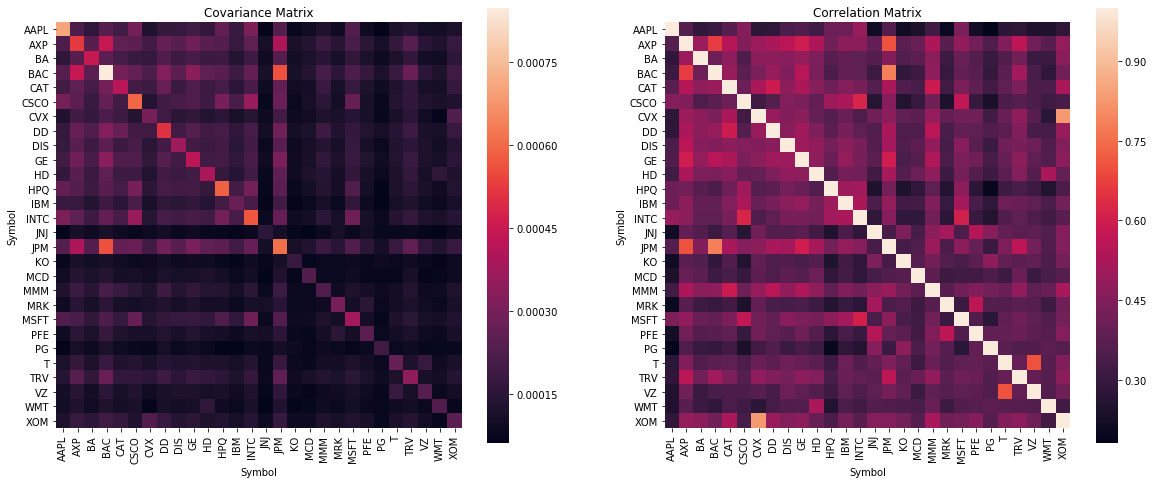

In [36]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

* Reordering variables group similar stocks together

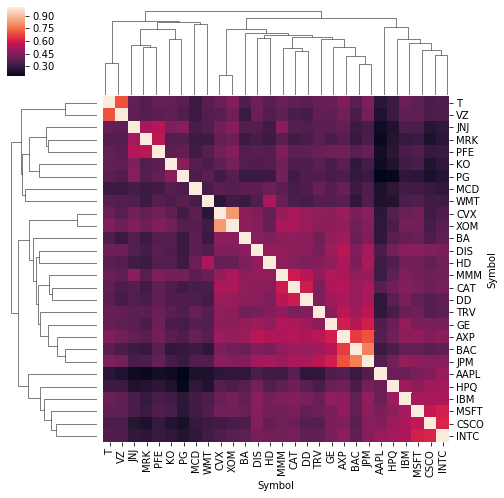

In [37]:
clmap = sns.clustermap(logret.corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

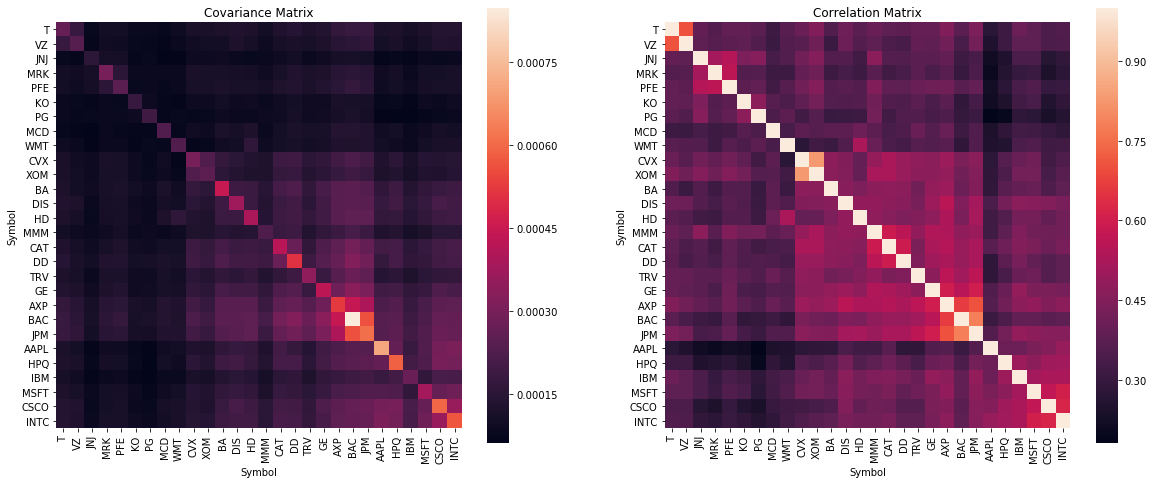

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr().iloc[ordering, ordering], square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

## Calculate Minimum Variance Portfolio

* $\Sigma$ matrix is all that is specified
* $\Sigma$ characterizes the market
* Minimize variance of portfolio $R_p$

In [39]:
import cvxpy as cvx

s, _ = sigma.shape # calculated from data

w = cvx.Variable(s) # variables
risk = cvx.quad_form(w, sigma.values)  # objective function
prob = cvx.Problem(cvx.Minimize(risk), # optimization problem 
               [cvx.sum(w) == 1])      # fully invested portfolio constraint
prob.solve()

8.698321065946202e-05

In [40]:
w.value

array([ 0.02014033, -0.07507116, -0.00686873, -0.01028328, -0.01082898,
       -0.01634386,  0.04270768, -0.04155391,  0.01104616, -0.01437098,
       -0.02261809,  0.01444665,  0.11143098, -0.02368283,  0.22019213,
       -0.0337178 ,  0.15556661,  0.14567807,  0.09454289,  0.00406313,
        0.01470036,  0.0321641 ,  0.12375195,  0.00673572,  0.01428235,
        0.10017497,  0.13084268,  0.01287286])

* Positive weights indicate long positions
* Negative weights indicate [short positions](https://en.wikipedia.org/wiki/Short_(finance))
* Must sum to 1 (constraint)

* Other portfolio optimization variations:  
    http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

* `cvxpy` package makes it easy to solve many types of problems easily
* Portfolio allocation problem with target expected return constraint:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

* Expected returns, $\mu$, is estimated from data (also $\Sigma$)
* Investor specifies target return $\mu^*$

In [41]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values*w >= 0.001
               ])
prob.solve()

0.00020658194161401347

In [42]:
w.value

array([ 0.27323396, -0.09437553,  0.06022901, -0.08056145,  0.18441941,
       -0.13350709,  0.34482683, -0.15228359,  0.09851376, -0.44326639,
        0.04902361, -0.09949472,  0.00079075, -0.07460622,  0.41206477,
        0.11455495,  0.11806182,  0.26990392,  0.2634796 , -0.06831378,
        0.0935414 , -0.02636621,  0.13689362, -0.1363117 ,  0.07655206,
        0.15763157,  0.03114486, -0.37577924])

* Higher target return achieved with more short positions
* Constraint: $\mu^\intercal w=0.001$
* Constraint: $\mathbf{1}^\intercal w=1$.

In [43]:
w.value.sum()

1.0

In [44]:
np.dot(mu.values,w.value)

0.0010000000000000005

### Making the investment

* Investing 1 dollar in a stock with 3% return over one time period makes me 3 cents:  
    $$\$1 \cdot (1 + 0.03) = 1.03$$
    
* Investing a portfolio of worth $A_0$ dollars returns,
    $$ A = A_0 (1+r_t^T w_t), $$
    where elements of $r_t$ are returns at time $t$ and $w$ is portfolio allocation

* Take allocation `w.value` and compute portfolio returns using historical returns: `logret`.

In [45]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)

* Compute portfolio growth

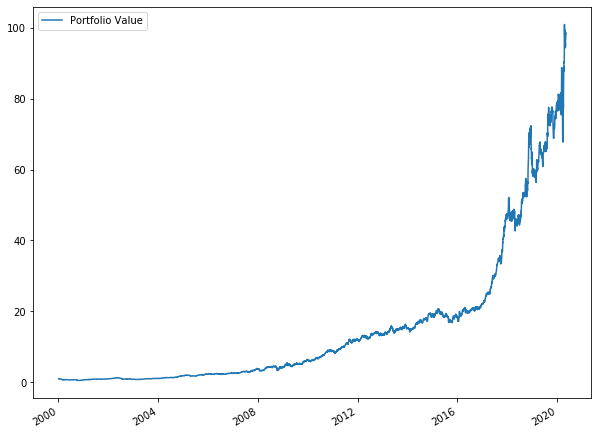

In [46]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot(figsize=(10, 8));

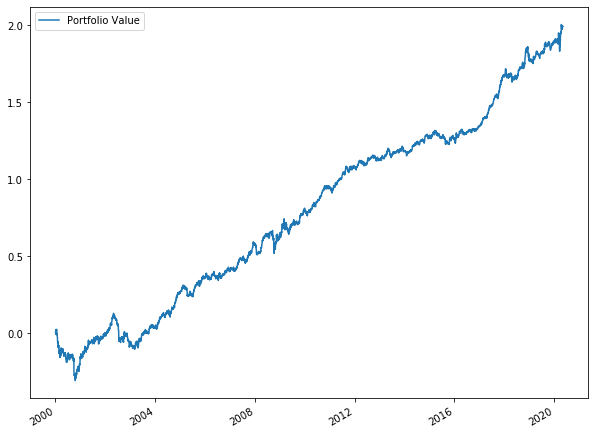

In [47]:
np.log10(ecp).plot(figsize=(10, 8));

In [48]:
ecp

,Portfolio Value
2000-01-04,0.997963
2000-01-05,1.012529
2000-01-06,1.017651
2000-01-07,1.059641
2000-01-10,1.027351
...,...
2020-05-04,97.020067
2020-05-05,97.676176
2020-05-06,97.850328
2020-05-07,98.529423


* 1 dollar invested in 2000 would be 98 dollars today?
* Unrealistic! Why?
* Having knowledge of 20 years worth of data is cheating!

### Quantify results

In [49]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max'])
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max'])
print('portfolio average returns:', earned.mean())
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.0009994070845034614
          average stddev : 0.01437021493694505

component stocks average: minimum: -0.000279
                          average: 0.000227
                          maximum: 0.000878
component stocks stddev : minimum: 0.012456
                          average: 0.019213
                          maximum: 0.029129


Annual return would be:

In [50]:
(1+earned.mean())**365 - 1

0.43993996760135157

Again, unrealistic

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [51]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns, index=logret.index[1:])

#### Correlation Matrix: 2020

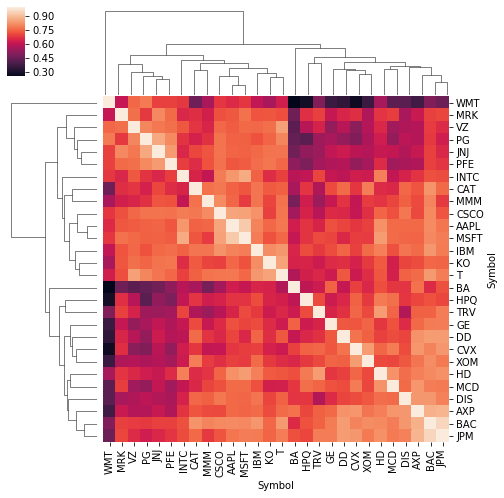

In [52]:
clmap = sns.clustermap(scaled_df.loc['2020':'2020'].corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

#### Correlation Matrix: 2019 vs. 2020

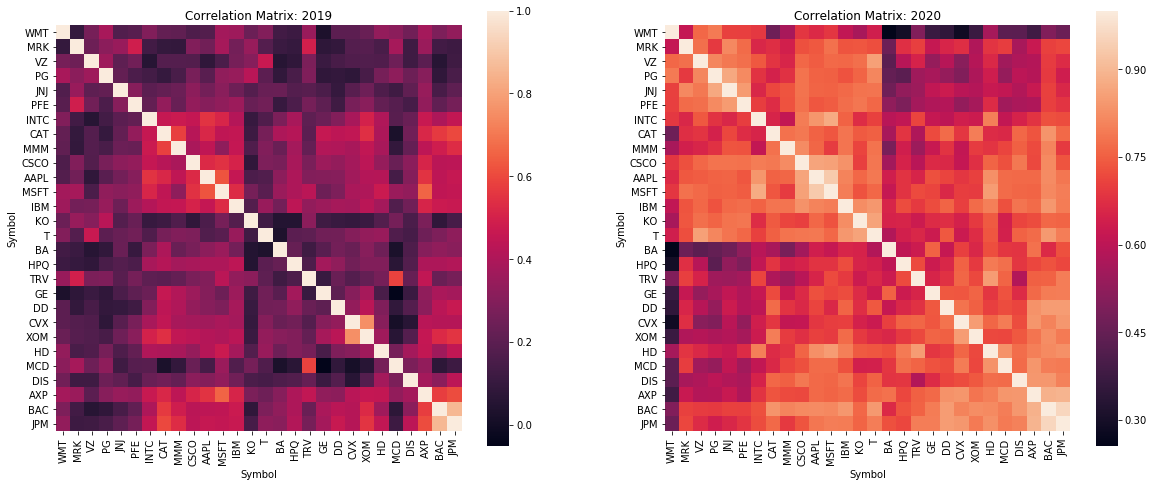

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(scaled_df.loc['2019':'2019'].corr().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Correlation Matrix: 2019')
sns.heatmap(scaled_df.loc['2020':'2020'].corr().iloc[ordering, ordering],  square=True, ax=ax[1]).set_title('Correlation Matrix: 2020')
fig.show()

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!